# Final Project: A Functional Tissue Unit Segmentation Program for Histology

In [1]:
from __future__ import print_function
from __future__ import division
import os
import shutil
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
from sklearn.metrics import average_precision_score
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pdb
from datetime import datetime
from plyer import notification
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import time
import copy
import random
import glob as gb
import cv2
import tifffile as tiff

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn



%matplotlib inline
%load_ext autoreload
%autoreload 2


#torch.use_deterministic_algorithms(True)    # Enforces reproducibility elsewhere as long as I seed

def seed_all(s):
    random.seed(s)
    torch.manual_seed(s)
    np.random.seed(s)
    
chosen_seed = 0
seed_all(chosen_seed)

## Check device

In [2]:
import torch
torch.cuda.empty_cache()

# Confirm that the GPU is detected
assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: NVIDIA GeForce RTX 3080 Laptop GPU, n_gpu: 1


## Set image size
Most images are originally 3000x3000 pixels.  This is quite large.  As a result, I run out of VRAM on a forward pass.  Here we set a size that all images will be consistently downscaled to.

In [3]:
IMSIZE = 512   # side length; as large as possible while not running out of RAM on my computer
# 1250 is too big
# 1000 fits but takes at least one hour per epoch on a batch size of 2
# 512 is the highest power of 2 that I can use without going over 16 GB VRAM while keeping a batch size of 2

## Load training and validation data

Number of training images : 1024
First training image : data/train_images\0_A001-C-023_cns_patch_0_0_largeintestine.tiff
Training image shapes:
{(4367, 4367, 3): 37, (3000, 3000, 3): 616, (2867, 2867, 3): 2, (2727, 2727, 3): 2, (2680, 2680, 3): 1, (2539, 2539, 3): 2, (2631, 2631, 3): 3, (2790, 2790, 3): 3, (2942, 2942, 3): 3, (2023, 2023, 3): 90, (2308, 2308, 3): 2, (2764, 2764, 3): 3, (2783, 2783, 3): 2, (2791, 2791, 3): 1, (2869, 2869, 3): 1, (2654, 2654, 3): 2, (2630, 2630, 3): 2, (2511, 2511, 3): 2, (2416, 2416, 3): 3, (2593, 2593, 3): 2, (2808, 2808, 3): 1, (2675, 2675, 3): 2, (1323, 1323, 3): 96, (160, 160, 3): 83, (2000, 2000, 3): 63}


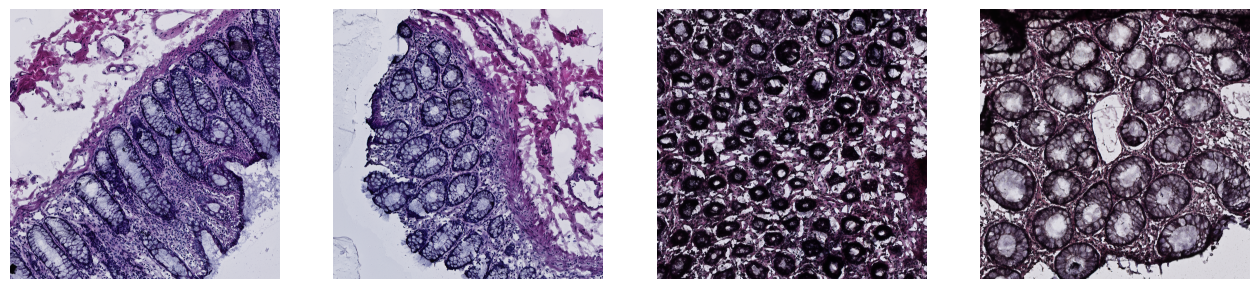

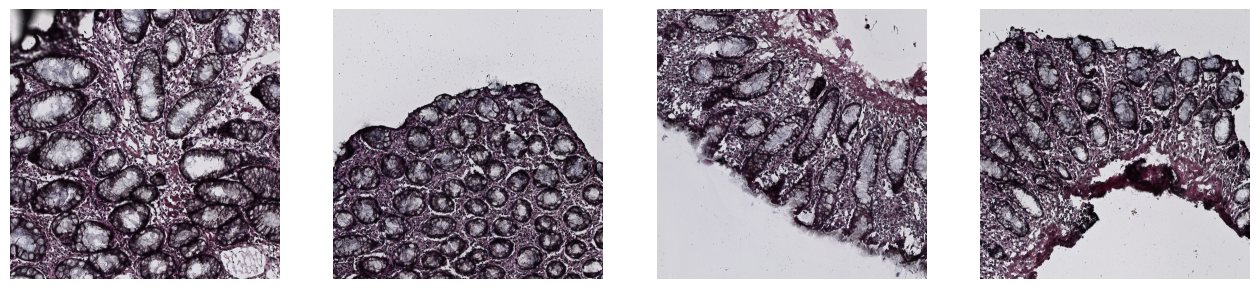

Number of validation images : 207
First validation image : data/val_images\0_A001-C-224_cns_patch_0_0_largeintestine.tiff
Validation image shapes:
{(4367, 4367, 3): 6, (3000, 3000, 3): 115, (2654, 2654, 3): 2, (2023, 2023, 3): 23, (2764, 2764, 3): 1, (2760, 2760, 3): 2, (2680, 2680, 3): 1, (3070, 3070, 3): 2, (2631, 2631, 3): 1, (2790, 2790, 3): 1, (2869, 2869, 3): 1, (2416, 2416, 3): 1, (2942, 2942, 3): 1, (160, 160, 3): 15, (1323, 1323, 3): 19, (2000, 2000, 3): 16}


In [4]:
# Borrows heavily from this code: https://www.kaggle.com/code/zakariajoudar/read-images-tiff-organ-segmentation

################ TRAINING DATA ################
# Read data
DATA_PATH = "data/"
submission = pd.read_csv(os.path.join(DATA_PATH, "sample_submission.csv"))
train_image_paths = sorted(gb.glob(os.path.join(DATA_PATH, 'train_images/*tiff')))
print(f"Number of training images : {len(train_image_paths)}")
print(f"First training image : {train_image_paths[0]}")


# Create a dictionary where keys are image shapes and values are number of images with that shape
train_image_shapes = {}
for ind, image_path in enumerate(train_image_paths):
    image = cv2.imread(image_path)
    train_image_shapes[image.shape] = train_image_shapes.get(image.shape, 0) + 1
print("Training image shapes:")
train_image_shapes
print(train_image_shapes)


# Visualize some of the images
n_cols = 4

for ind, image_path in enumerate(train_image_paths[:8]):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if ind % n_cols == 0:
        plt.figure(figsize=(16,5))
        
    plt.subplot(1, n_cols, ind % n_cols + 1)
    plt.imshow(image)
    plt.axis("off")
    if ind % n_cols == n_cols - 1:
        plt.show()

################ VALIDATION DATA ################
# Read data
val_image_paths = sorted(gb.glob(os.path.join(DATA_PATH, 'val_images/*tiff')))
print(f"Number of validation images : {len(val_image_paths)}")
print(f"First validation image : {val_image_paths[0]}")

# Create a dictionary where keys are image shapes and values are number of images with that shape
val_image_shapes = {}
for ind, image_path in enumerate(val_image_paths):
    image = cv2.imread(image_path)
    val_image_shapes[image.shape] = val_image_shapes.get(image.shape, 0) + 1
print("Validation image shapes:")
print(val_image_shapes)


In [5]:
from torch.utils.data import Dataset
from wrens_utils import CustomImageDataset

## Format labels

In [6]:
from wrens_utils import rle_to_mask

## Define loss function

In [7]:
# Define dice loss
# Borrows heavily from https://www.kaggle.com/code/hyunwoo2/training-with-thickness-and-staining-augmentation/notebook

'''
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
    
    def forward(self, inputs, targets, mode=1, smooth=1):
        """
        :param inputs: (BS, 3, IMSIZE, IMSIZE) after sigmoid function
        :param targets: (BS, 3, IMSIZE, IMSIZE)
        :param mode: If 0, compute dice coefficient.  If 1, compute dice loss.  loss = 1 - coefficient
        """
        # Handle errors
        # Inputs wrong size
        # Targets wrong size
        
        b_sz = inputs.shape[0]
        dice_sum = torch.FloatTensor([0]).cuda()
        for i in range(b_sz):
            # Flatten input and target tensors
            input = inputs[i,:].view(-1)
            target = targets[i,:].view(-1)
            # Compute the dice coefficient
            intersection = (input * target).sum()
            dice = (2 * intersection + smooth) / (input.sum() + targets.sum() + smooth)
            dice_sum += dice
        mean_dice = dice / b_sz

        if mode == 1:
            return 1 - mean_dice
        else:
            return mean_dice.item()
'''

'\nclass DiceLoss(nn.Module):\n    def __init__(self, weight=None, size_average=True):\n        super(DiceLoss, self).__init__()\n    \n    def forward(self, inputs, targets, mode=1, smooth=1):\n        """\n        :param inputs: (BS, 3, IMSIZE, IMSIZE) after sigmoid function\n        :param targets: (BS, 3, IMSIZE, IMSIZE)\n        :param mode: If 0, compute dice coefficient.  If 1, compute dice loss.  loss = 1 - coefficient\n        """\n        # Handle errors\n        # Inputs wrong size\n        # Targets wrong size\n        \n        b_sz = inputs.shape[0]\n        dice_sum = torch.FloatTensor([0]).cuda()\n        for i in range(b_sz):\n            # Flatten input and target tensors\n            input = inputs[i,:].view(-1)\n            target = targets[i,:].view(-1)\n            # Compute the dice coefficient\n            intersection = (input * target).sum()\n            dice = (2 * intersection + smooth) / (input.sum() + targets.sum() + smooth)\n            dice_sum += dice\n

## Demos (optional)

In [8]:
# Demo the pretrained model on dog segmentation
# Borrows heavily from here: https://pytorch.org/vision/stable/models.html#semantic-segmentation

from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image

"""
from torch.utils.data import DataLoader

seed_all(chosen_seed)
BS=1

# Create transforms
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMSIZE, IMSIZE)),
    transforms.RandomAdjustSharpness(sharpness_factor=0, p=0.5),
    transforms.ColorJitter(brightness=0.5, hue=0.3),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),    # Values chosen from here: https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/
])
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMSIZE, IMSIZE)),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# Create custom Datasets
train_dataset = CustomImageDataset(annotations_file=os.path.join(DATA_PATH, "train.csv"), img_dir=os.path.join(DATA_PATH, "train_images/"), transform=train_transforms, target_transform=None, imsize=IMSIZE)
val_dataset = CustomImageDataset(annotations_file=os.path.join(DATA_PATH, "val.csv"), img_dir=os.path.join(DATA_PATH, "val_images/"), transform=val_transforms, target_transform=None, imsize=IMSIZE)

# Create custom DataLoaders to wrap the Datasets
train_dataloader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BS, shuffle=True)


######## LOAD PRETRAINED MODEL TO BE FINETUNED ########
# Borrows heavily from here: https://pytorch.org/vision/stable/models.html#semantic-segmentation

from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights

# Initialize model with the best available weights
weights = DeepLabV3_ResNet101_Weights.DEFAULT
model = deeplabv3_resnet101(weights=weights)
model.cuda()

img = read_image("misc/dog.jpg")

model.eval()
preprocess = weights.transforms()
batch = preprocess(img).unsqueeze(0).to(device)

prediction = model(batch)["out"]
normalized_masks = prediction.softmax(dim=1)
class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
mask = normalized_masks[0, class_to_idx["dog"]]     # Ranges from 0 (there's nothing here) to 1 (there's something here)

to_pil_image(mask).show()
"""

'\nfrom torch.utils.data import DataLoader\n\nseed_all(chosen_seed)\nBS=1\n\n# Create transforms\ntrain_transforms = transforms.Compose([\n    transforms.ToTensor(),\n    transforms.Resize((IMSIZE, IMSIZE)),\n    transforms.RandomAdjustSharpness(sharpness_factor=0, p=0.5),\n    transforms.ColorJitter(brightness=0.5, hue=0.3),\n    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),    # Values chosen from here: https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/\n])\nval_transforms = transforms.Compose([\n    transforms.ToTensor(),\n    transforms.Resize((IMSIZE, IMSIZE)),\n    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),\n])\n\n# Create custom Datasets\ntrain_dataset = CustomImageDataset(annotations_file=os.path.join(DATA_PATH, "train.csv"), img_dir=os.path.join(DATA_PATH, "train_images/"), transform=train_transforms, target_transform=None)\nval_dataset = CustomImageDataset(annotations_file=os.path.join(DATA_PATH, "val.c

In [9]:
# Demo the pretrained model on an image from our dataset

"""
from torch.utils.data import DataLoader

seed_all(chosen_seed)
BS=1

# Create transforms
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMSIZE, IMSIZE)),
    transforms.RandomAdjustSharpness(sharpness_factor=0, p=0.5),
    transforms.ColorJitter(brightness=0.5, hue=0.3),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),    # Values chosen from here: https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/
])
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMSIZE, IMSIZE)),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# Create custom Datasets
train_dataset = CustomImageDataset(annotations_file=os.path.join(DATA_PATH, "train.csv"), img_dir=os.path.join(DATA_PATH, "train_images/"), transform=train_transforms, target_transform=None, imsize=IMSIZE)
val_dataset = CustomImageDataset(annotations_file=os.path.join(DATA_PATH, "val.csv"), img_dir=os.path.join(DATA_PATH, "val_images/"), transform=val_transforms, target_transform=None, imsize=IMSIZE)

# Create custom DataLoaders to wrap the Datasets
train_dataloader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BS, shuffle=True)


######## LOAD PRETRAINED MODEL TO BE FINETUNED ########
# Borrows heavily from here: https://pytorch.org/vision/stable/models.html#semantic-segmentation

from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights

# Initialize model with the best available weights
weights = DeepLabV3_ResNet101_Weights.DEFAULT
model = deeplabv3_resnet101(weights=weights)
model.cuda()

image, labels = next(iter(train_dataloader))
img = image[0].squeeze()
img_for_plotting = img.movedim(-1, 0)
to_pil_image(img_for_plotting).show()
label = labels[0]
to_pil_image(label * 255).show()

model.eval()
batch = img.unsqueeze(0).to(device)
batch = batch.movedim(-1, 1)    # Gives batch a size of [1, 3, 1250, 1250]

prediction = model(batch)["out"]
normalized_masks = prediction.softmax(dim=1)
class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
mask = normalized_masks[0, class_to_idx["cat"]]     # Ranges from 0 (there's nothing here) to 1 (there's something here)

to_pil_image(mask * 255).show()
"""

'\nfrom torch.utils.data import DataLoader\n\nseed_all(chosen_seed)\nBS=1\n\n# Create transforms\ntrain_transforms = transforms.Compose([\n    transforms.ToTensor(),\n    transforms.Resize((IMSIZE, IMSIZE)),\n    transforms.RandomAdjustSharpness(sharpness_factor=0, p=0.5),\n    transforms.ColorJitter(brightness=0.5, hue=0.3),\n    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),    # Values chosen from here: https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/\n])\nval_transforms = transforms.Compose([\n    transforms.ToTensor(),\n    transforms.Resize((IMSIZE, IMSIZE)),\n    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),\n])\n\n# Create custom Datasets\ntrain_dataset = CustomImageDataset(annotations_file=os.path.join(DATA_PATH, "train.csv"), img_dir=os.path.join(DATA_PATH, "train_images/"), transform=train_transforms, target_transform=None)\nval_dataset = CustomImageDataset(annotations_file=os.path.join(DATA_PATH, "val.c

## Load and finetune model

In [10]:
# Define training
def train_model(train_loader, model, criterion, optimizer):#, original_weights):
    model.train()
    loss_ = 0.0
    losses = []
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        images = images.movedim(-1, 1)  # Change from [N, W, H, C] to [N, C, W, H] (or maybe W and H are reversed)
        optimizer.zero_grad()
        logits = model(images)#["out"]
        #logits = logits.softmax(dim=1)     # TODO: If this line is harmful, remove it
        #class_to_idx = {cls: idx for (idx, cls) in enumerate(original_weights.meta["categories"])}
        #logits = logits[:, class_to_idx["sofa"], :, :]
        logits = logits.squeeze()
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss)
    return torch.stack(losses).mean().item()


In [11]:
# Define validation and testing
def test_model(test_loader, model, criterion):#, original_weights):
    model.eval()
    losses = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):    # Each iteration is one minibatch
            images, labels = images.to(device), labels.to(device)
            images = images.movedim(-1, 1)  # Change from [N, W, H, C] to [N, C, W, H] (or maybe W and H are reversed)
            logits = model(images)#["out"]
            #logits = logits.softmax(dim=1)     # TODO: If this line is harmful, remove it
            #class_to_idx = {cls: idx for (idx, cls) in enumerate(original_weights.meta["categories"])}
            #logits = logits[:, class_to_idx["sofa"], :, :]
            logits = logits.squeeze()
            loss = criterion(logits, labels)
            losses.append(loss.item())
        
        test_loss = np.mean(losses)
        print('Validation/testing loss: {}'.format(test_loss))
    
    # Return metrics
    return test_loss

In [12]:
# Define a full course of training
def perform_training(NUM_EPOCHS, TEST_FREQUENCY, BS, WD, LR):
    seed_all(chosen_seed)
    print(f"\nBEGINNING TRAINING FOR BS={BS}, WD={WD}, LR={LR}")

    ######## SET UP TRANSFORMS, DATASETS, AND DATALOADERS ########
    from torch.utils.data import DataLoader

    seed_all(chosen_seed)

    # Create transforms
    train_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((IMSIZE, IMSIZE)),
        transforms.RandomAdjustSharpness(sharpness_factor=0, p=0.5),
        # TODO: RE-ENABLE COLORJITTER IF IT LEADS TO BETTER RESULTS
        #transforms.ColorJitter(brightness=0.5, hue=0.3),
        # TODO: RE-ENABLE NORMALIZATION IF IT LEADS TO BETTER RESULTS
        #transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),    # Values chosen from here: https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/
    ])
    val_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((IMSIZE, IMSIZE)),
        # TODO: RE-ENABLE NORMALIZATION IF IT LEADS TO BETTER RESULTS
        #transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

    # Create custom Datasets
    train_dataset = CustomImageDataset(annotations_file=os.path.join(DATA_PATH, "train.csv"), img_dir=os.path.join(DATA_PATH, "train_images/"), transform=train_transforms, target_transform=None, imsize=IMSIZE)
    val_dataset = CustomImageDataset(annotations_file=os.path.join(DATA_PATH, "val.csv"), img_dir=os.path.join(DATA_PATH, "val_images/"), transform=val_transforms, target_transform=None, imsize=IMSIZE)

    # Create custom DataLoaders to wrap the Datasets
    train_dataloader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BS, shuffle=True)

    # Set up plotting variables
    epoch_vector = [ii for ii in range(0, NUM_EPOCHS, TEST_FREQUENCY)]
    training_loss_vector = []
    validation_loss_vector = []

    
    ######## LOAD PRETRAINED MODEL TO BE FINETUNED ########
    # Borrows heavily from here: https://pytorch.org/vision/stable/models.html#semantic-segmentation

    from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights

    # Initialize model with the best available weights
    # TODO: Choose DeepLabV3 or UNet
    # DeepLabV3:
    """
    weights = DeepLabV3_ResNet101_Weights.DEFAULT
    model = deeplabv3_resnet101(weights=weights)
    model.cuda()
    """
    # UNet:
    # Borrows heavily from here: https://segmentation-modelspytorch.readthedocs.io/en/latest/#examples
    #"""
    enc_name = "resnet101"
    enc_weights = "imagenet"
    model = smp.Unet(encoder_name=enc_name, encoder_depth=5,
                     encoder_weights=enc_weights, decoder_use_batchnorm=True,
                     decoder_channels=[256, 128, 64, 32, 16],
                     in_channels=3, classes=1)     # TODO: Do I need to give a value for the `activation` argument?
    model = model.cuda()
    #"""


    # Create criterion
    #criterion = DiceLoss()
    criterion = smp.losses.DiceLoss(mode="binary", smooth=0)

    # Create optimizer
    # TODO: Re-enable regular Adam if better than Ranger
    """
    optimizer = torch.optim.Adam(params=model.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, weight_decay=WD)
    """
    # TODO: Disable Ranger if worse than Adam
    #"""
    from ranger_deep_learning_optimizer.pytorch_ranger import Ranger  # this is from ranger.py
    from ranger_deep_learning_optimizer.pytorch_ranger import RangerVA  # this is from ranger913A.py
    from ranger_deep_learning_optimizer.pytorch_ranger import RangerQH  # this is from rangerqh.py
    optimizer = Ranger(model.parameters(), lr=LR)
    #"""
    
    
    ######## TRAIN ########
    # Training
    best_val_loss = float("inf")
    best_val_epoch = 0
    for epoch in range(0, NUM_EPOCHS):
        print(f"Starting epoch number {epoch+1} / {NUM_EPOCHS}")
        train_loss = train_model(train_dataloader, model, criterion, optimizer)#, weights)
        print("Loss for Training on Epoch " + str(epoch) + " is "+ str(train_loss))
        # Run a test if it's time
        if(epoch%TEST_FREQUENCY==0):
            print('Evaluating model')
            val_loss = test_model(val_dataloader, model, criterion)#, weights)
            training_loss_vector.append(train_loss)
            validation_loss_vector.append(val_loss)
            print(f"Training loss on epoch {epoch+1} is {train_loss}")
            print(f"Validation loss on epoch {epoch+1} is {val_loss}")
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_val_epoch = epoch
                removal_pattern = f"trained_models/modeldate*_bs{BS}_lr{LR}_wd{WD}_epochs*_imsize{IMSIZE}_valloss*.pth"
                for file in gb.glob(removal_pattern):   # Remove earlier versions of this model that have worse validation loss
                    os.remove(file)
                savename = f"trained_models/modeldate{str(datetime.now()).replace(':', '_').replace(' ', ',')}_bs{BS}_lr{LR}_wd{WD}_epochs{epoch+1}_imsize{IMSIZE}_valloss{round(val_loss, 4)}.pth"
                torch.save(model.state_dict(), savename)
                print("SAVED MODEL")
    # Test and add a final datapoint if one wasn't already added for this epoch
    if epoch_vector[-1] != epoch:
        epoch_vector.append(epoch)
        print('Evaluating model')
        val_loss = test_model(val_dataloader, model, criterion)#, weights)
        training_loss_vector.append(train_loss)
        validation_loss_vector.append(val_loss)
        print(f"Training loss on epoch {epoch+1} is {train_loss}")
        print(f"Validation loss on epoch {epoch+1} is {val_loss}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_epoch = epoch
            removal_pattern = f"trained_models/modeldate*_bs{BS}_lr{LR}_wd{WD}_epochs*_imsize{IMSIZE}_valloss*.pth"
            for file in gb.glob(removal_pattern):   # Remove earlier versions of this model that have worse validation loss
                os.remove(file)
            savename = f"trained_models/modeldate{str(datetime.now()).replace(':', '_').replace(' ', ',')}_bs{BS}_lr{LR}_wd{WD}_epochs{epoch+1}_imsize{IMSIZE}_valloss{round(val_loss, 4)}.pth"
            torch.save(model.state_dict(), savename)
            print("SAVED MODEL")
    # Print best accuracy and when it was obtained
    print(f"LOWEST VALIDATION LOSS WAS {best_val_loss} AT EPOCH {best_val_epoch}")
    
    # Plot
    fig, axs = plt.subplots(2)
    axs[0].plot(epoch_vector, training_loss_vector, color="blue")
    axs[0].plot(epoch_vector, validation_loss_vector, color="orange")
    axs[0].set(xlabel="epochs", ylabel="loss")
    axs[0].legend(["training loss", "validation loss"])
    plt.savefig(f"trained_models/modeldate{str(datetime.now()).replace(':', '_').replace(' ', ',')}_bs{BS}_lr{LR}_wd{WD}_epochs{epoch+1}_imsize{IMSIZE}_valloss{round(val_loss, 4)}.png")
    plt.show()

    # Notify that we're done
    notification.notify(
        title = 'Done training and saving model!',
        message = 'message',
        app_icon = None,
        timeout = 10,
    )


BEGINNING TRAINING FOR BS=4, WD=0, LR=1e-05
Starting epoch number 1 / 100


c:\Users\User\Documents\ClassNotes\QuickNotes\PythonProjects\jupyter_cs_682_final_project\ranger_deep_learning_optimizer\pytorch_ranger\ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\python_arg_parser.cpp:1174.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


Loss for Training on Epoch 0 is 0.7592933177947998
Evaluating model
Validation/testing loss: 0.7138987527443812
Training loss on epoch 1 is 0.7592933177947998
Validation loss on epoch 1 is 0.7138987527443812
SAVED MODEL
Starting epoch number 2 / 100
Loss for Training on Epoch 1 is 0.702721357345581
Evaluating model
Validation/testing loss: 0.6564408999222976
Training loss on epoch 2 is 0.702721357345581
Validation loss on epoch 2 is 0.6564408999222976
SAVED MODEL
Starting epoch number 3 / 100
Loss for Training on Epoch 2 is 0.631026029586792
Evaluating model
Validation/testing loss: 0.5849249523419601
Training loss on epoch 3 is 0.631026029586792
Validation loss on epoch 3 is 0.5849249523419601
SAVED MODEL
Starting epoch number 4 / 100
Loss for Training on Epoch 3 is 0.5735923051834106
Evaluating model
Validation/testing loss: 0.5311454144807962
Training loss on epoch 4 is 0.5735923051834106
Validation loss on epoch 4 is 0.5311454144807962
SAVED MODEL
Starting epoch number 5 / 100
Loss

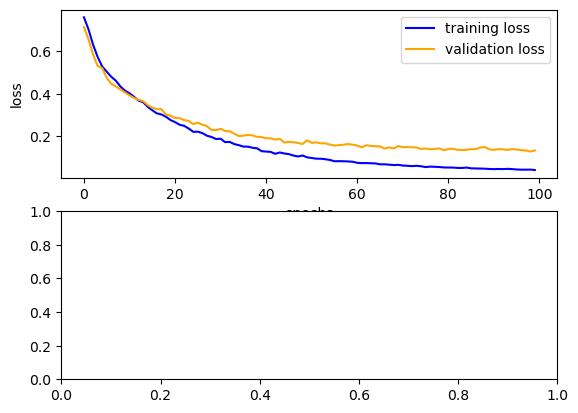

In [13]:
# Run grid search

combinations_to_skip = []

# Batch size
# My choices are informed by the fact that larger batch sizes are usually better, up to the limit of what my computer's RAM can handle.
# Furthermore, batch size must be at least 2 while training, or else this error occurs: https://discuss.pytorch.org/t/error-expected-more-than-1-value-per-channel-when-training/26274
options_bs = [4]  # 4 is the highest power of 2 that I can use in conjunction with my best resolution, without going over 16 GB VRAM

# Weight decay (for Adam)
# My choices are informed by the fact that weight decay is usually tested on a logarithmic scale.  Source: https://hasty.ai/docs/mp-wiki/solvers-optimizers/weight-decay
# The values I test are very low because this is a complicated task, so we don't want to force our model to be too simple.
options_wd = [0]

# Learning rate (for Adam)
# My choices are informed by the fact that the pretrained model used a learning rate of 0.02.  Source: https://github.com/pytorch/vision/tree/main/references/segmentation#fcn_resnet101
#options_lr = [2e-6, 4e-6, 8e-6, 2e-5, 4e-5, 8e-5, 2e-4]
options_lr = [1e-5]


for this_bs in options_bs:
    for this_wd in options_wd:
        for this_lr in options_lr:
            if [this_bs, this_wd, this_lr] not in combinations_to_skip:
                perform_training(NUM_EPOCHS=100, TEST_FREQUENCY=1, BS=this_bs, WD=this_wd, LR=this_lr)

## Plot heatmap of coarse grid search results

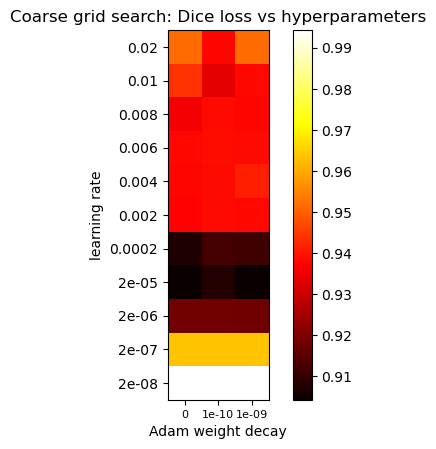

In [14]:
best_val_accuracies = np.array([[0.9516, 0.9378, 0.9516],
                                [0.9438, 0.9335, 0.9383],
                                [0.9359, 0.9385, 0.9377],
                                [0.9383, 0.9389, 0.9386],
                                [0.9378, 0.9385, 0.9414],
                                [0.9376, 0.9385, 0.9384],
                                [0.9073, 0.9122, 0.9114],
                                [0.9043, 0.9078, 0.9044],
                                [0.9185, 0.9184, 0.9183],
                                [0.9635, 0.9634, 0.9635],
                                [0.9943, 0.9943, 0.9943],])
heatmap = plt.imshow(best_val_accuracies, cmap="hot", interpolation="nearest")
plt.title("Coarse grid search: Dice loss vs hyperparameters")
plt.ylabel("learning rate")
plt.xlabel("Adam weight decay")
plt.yticks(range(11), [2e-2, 1e-2, 8e-3, 6e-3, 4e-3, 2e-3, 2e-4, 2e-5, 2e-6, 2e-7, 2e-8])
plt.xticks([0, 1, 2], [0, 1e-10, 1e-9], fontsize=8)
plt.colorbar(heatmap)
plt.show()

## Plot heatmap of fine grid search results

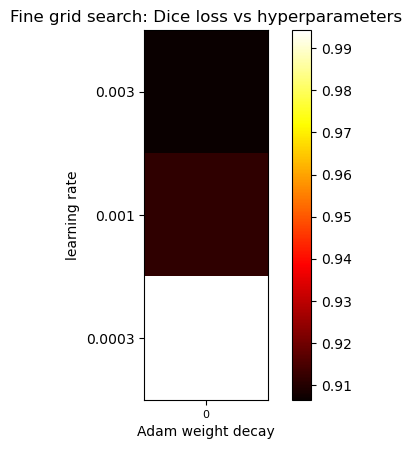

In [15]:
best_val_accuracies = np.array([[0.9065],
                                [0.9114],
                                [0.9943],])
heatmap = plt.imshow(best_val_accuracies, cmap="hot", interpolation="nearest")
plt.title("Fine grid search: Dice loss vs hyperparameters")
plt.ylabel("learning rate")
plt.xlabel("Adam weight decay")
plt.yticks(range(3), [3e-3, 1e-3, 3e-4])
plt.xticks([0], [0], fontsize=8)
plt.colorbar(heatmap)
plt.show()